In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

### Importing Data

In [2]:
psych = pd.read_csv('../Data/Processed_Data/MergedFinal.csv')

In [3]:
psych.head()

,Rating,compound1,Anxiety Disorders,Bipolar Disorders,Depressive Disorders,Neurodevelopmental Disorders,Obsessive-Compulsive Disorders,Personality Disorders,Psychotic Disorders,Trauma-related Disorders,...,took,tried,week,weeks,weight,went,work,worked,year,years
0,8.0,1.9172,0,0,0,1,0,0,0,0,...,0.0,0.231364,0.466684,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,10.0,0.0911,0,1,0,0,0,0,0,0,...,0.0,0.328339,0.000000,0.0,0.000000,0.336281,0.0,0.000000,0.000000,0.000000
2,10.0,1.0147,0,0,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.320926
3,10.0,0.2148,0,1,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,10.0,0.4327,0,0,0,1,0,0,0,0,...,0.0,0.486605,0.000000,0.0,0.500136,0.249187,0.0,0.261021,0.253855,0.183790


In [5]:
psych.shape

(30918, 79)

### Combining similar vectors (proxy)

I noticed (retrospectively) that a few of my features were TFIDF generated vectors that were very similar in meaning (i.e. same words different tense); I researched how TFIDF vector scores were calculated, and decided to combine these features into one so it serves as a proxy for lemmatization:

In [13]:
psych['years_tf'] = psych['year'] + psych['years']

In [14]:
psych['week_tf'] = psych['week'] + psych['weeks']

In [15]:
psych['days_tf'] = psych['day'] + psych['days']

In [16]:
psych['feel_tf'] = psych['feel'] + psych['feeling'] + psych['felt']

In [17]:
psych = psych.drop(columns = ['year', 'years', 'week', 'weeks', 'day', 'days'
                             ,'feel', 'feeling', 'felt'], axis = 1)

In [50]:
psych.shape

(30918, 74)

### Train-Test Split

In [6]:
X = psych.drop(columns = 'Rating', axis = 1)

In [7]:
y = psych['Rating']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Naive Bayes

In [54]:
mnb = MultinomialNB()

In [55]:
mnb.fit(X_train, y_train)
mnb.score(X_train, y_train), mnb.score(X_test, y_test)

(0.347076073831292, 0.3486416558861578)

The scores are very low (0.35 for both train & test). I'm curious to see if doing a simple logistic regression might be a better direction to take:

### Logistic Regresion

In [68]:
logreg = LogisticRegression(solver = 'liblinear', penalty = 'l2')

In [69]:
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.37083836467138176, 0.3714100905562743)

The scores for the logistic regression are a little better than the Naive Bayes model (0.37 for both train & test), but low. <br><br> After doing some research, based on my features it may be best to try a Random Forest model:

### Random Forest Regressor

In [24]:
rfr = RandomForestRegressor(max_features = 8)

In [25]:
rfr.fit(X_train, y_train)
rfr.score(X_train, y_train), rfr.score(X_test, y_test)

(0.9335657692326066, 0.5628603782102022)

Model is very overfit; the train accuracy is good but test accuracy is very low. I will try using a RandomForestClassifier instead; all of my predictors/features were initially categorical to begin with (prior to transforming/dummifying) so it made sense to have a categorical target as well. 

### Random Forest Classifier (10 class prediction)

In [26]:
rfc = RandomForestClassifier(max_features = 8)

In [27]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9965499396239434, 0.635058214747736)

This model performed slightly better than the Random Forest Regressor but it is still very overfit (train accuracy almost 1 but test accuracy is pretty low at 0.64). Will try testing different hyperparemters to see if this helps:<br>

In [60]:
rfc = RandomForestClassifier(max_depth = 24, max_features = 9)

In [61]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9589874072796274, 0.6159120310478654)

Seems like the scores are similar to the first RFC model, with 0.96 for train and 0.62 for test; I will try inceasing the number of n_estimators from the default (100) to 1000 to see if this improves my model:

In [62]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, max_features = 9)

In [63]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9624805934103847, 0.6216041397153945)

The model performed about the same as the previous even after adding more n_estimators (0.96 train & 0.62 test). After doing some research I decided to add class_weight as a hyperparameter to help deal with the imbalanced classes in my target variable:

In [64]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, 
                             max_features = 9, class_weight = 'balanced')

In [65]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.977315853027428, 0.6213454075032342)

The train score improved by a little bit but the test score is the same (0.98 train, 0.62 test); will try adding the oob_score hyperparameter as well:

In [72]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, 
                             max_features = 9, class_weight = 'balanced',
                            oob_score = True)

In [73]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9781783681214421, 0.6200517464424321)

Model has the same results (0.98 train, 0.62 test); the last few models I've run have all been pretty overfit. Will try adding the 'criterion' hyperparameter to see if it helps with the overfitting:

In [77]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, 
                             max_features = 9, class_weight = 'balanced',
                            oob_score = True, criterion = 'entropy')

In [78]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.985423494911161, 0.6316946959896507)

The accuracy score for train went up from 0.98 to 0.99, and test went up by 0.01 as well (0.62 to 0.63); the model is still overfit. <br><br> I will try reclassifying the target variable as 3 classes (low, medium, & high) to see if this helps better the model.

### Random Forest Classifier (3 class prediction)

In [101]:
def f(row):
    if row['Rating'] <= 3:
        return 1
    elif row['Rating'] <= 7:
        return 2
    else:
        return 3

**Note**: 'Low' ratings classified is 1-3, 'Medium' as 4-7 and 'High' as 8 or above

In [102]:
psych['Rating_cat'] = psych.apply(f, axis = 1)

In [104]:
psych['Rating_cat'].value_counts()

3    20245
1     5357
2     5316
Name: Rating_cat, dtype: int64

Looks like the classes are quite imbalanced, with about 65% belonging to the 'High' rating class. Will definitely need to account for that in my RFC model by including the class_weight hyperparameter.

In [105]:
psych.head()

,Rating,compound1,Anxiety Disorders,Bipolar Disorders,Depressive Disorders,Neurodevelopmental Disorders,Obsessive-Compulsive Disorders,Personality Disorders,Psychotic Disorders,Trauma-related Disorders,Anxiolytics,B vitamin,MAOI,NRDI,SARI,SNRI,SSRI,SSRI/5HT-1A Partial Agonist,TeCA,alpha agonists,anticonvulsants,antihistamines,antihypertensives,antimanic agents,anxiolytics,atypical antipsychotics,benzodiazepines,beta blockers,central nervous system stimulants,conventional antipsychotics,tricyclic antidepressants,ago,anxiety,attacks,bad,better,depression,did,didnt,doctor,dont,dose,drug,effects,good,great,help,helped,im,ive,just,life,like,medication,medicine,months,night,panic,prescribed,really,sleep,started,taking,time,took,tried,weight,went,work,worked,years_tf,week_tf,days_tf,feel_tf,Rating_cat
0,8.0,1.9172,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.203022,0.000000,0.227612,0.0,0.213254,0.0,0.233223,0.0,0.000000,0.227833,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.183442,0.164529,0.000000,0.0,0.231364,0.000000,0.000000,0.0,0.000000,0.000000,0.466684,0.650502,0.000000,3
1,10.0,0.0911,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.288118,0.251365,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.257267,0.00000,0.0,0.258745,0.505013,0.000000,0.000000,0.00000,0.0,0.0,0.347716,0.0,0.000000,0.260331,0.000000,0.000000,0.0,0.328339,0.000000,0.336281,0.0,0.000000,0.000000,0.000000,0.000000,0.236771,3
2,10.0,1.0147,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0.372802,0.325247,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.314417,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.326724,0.000000,0.000000,0.36691,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.302118,0.356197,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.320926,0.000000,0.000000,0.306363,3
3,10.0,0.2148,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.279727,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.435728,0.0,0.0,0.000000,0.36248,0.0,0.000000,0.330040,0.000000,0.400823,0.00000,0.0,0.0,0.000000,0.0,0.411276,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.402206,0.000000,3
4,10.0,0.4327,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.224258,0.0,0.000000,0.0,0.180062,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.187110,0.201708,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.233165,0.192908,0.000000,0.000000,0.0,0.486605,0.500136,0.249187,0.0,0.261021,0.437645,0.000000,0.186126,0.000000,3


In [106]:
psych.shape

(30918, 75)

In [107]:
X = psych.drop(columns = ['Rating', 'Rating_cat'])
y = psych['Rating_cat']

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [109]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, 
                             max_features = 9, class_weight = 'balanced',
                            oob_score = True, criterion = 'entropy')

In [110]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9797740210453683, 0.811901681759379)

The RFC model predicting 3 classes of Drug Ratings instead of 10 classes is doing much better. The accuracy score of train is still high (0.98) but the test accuracy went up to 0.81, which signifies that the model is the least overfit of all the RFC models thus far. Though it is still a bit overfit, a test accuracy of 0.81 is decent.<br><br> Was also curious to try changing class weight from 'balanced' to 'balanced_sibsample' to see if this helps the model:

In [111]:
rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, 
                             max_features = 9, class_weight = 'balanced_subsample',
                            oob_score = True, criterion = 'entropy')

In [112]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9798602725547697, 0.8124191461836999)

Looks like the results are comprable to the model above (0.98 train and 0.81 test). This model is pretty good and seems to be my best model thus far so will select this model as my final.

### Final Model Metrics

In [113]:
y_pred2 = rfc.predict(X_test)

In [138]:
accuracy_score(y_test, y_pred2)

0.8124191461836999

In [116]:
f1_score(y_test, y_pred2, average = None)

array([0.70661308, 0.5822156 , 0.88272642])

In [117]:
f1_score(y_test, y_pred2, average = 'macro')

0.7238517008421833

In [118]:
f1_score(y_test, y_pred2, average = 'weighted')

0.7997869148706447

The model metrics I will likely report/am most intersted in for this model are the f1 score for the 'low' & 'high' category (0.71, 0.88 respectively)as well as the weighted f1 score, which is the average of the f1 scores of all 3 categories but with class weight factored in (0.80). Overall, the f1 scores are pretty good, suggesting the model can successfully predict the class of low and high drug ratings (which is what physicians & drug manufacturers may be most intersted in).

In [120]:
cm2 = confusion_matrix(y_test, y_pred2)

<AxesSubplot:>

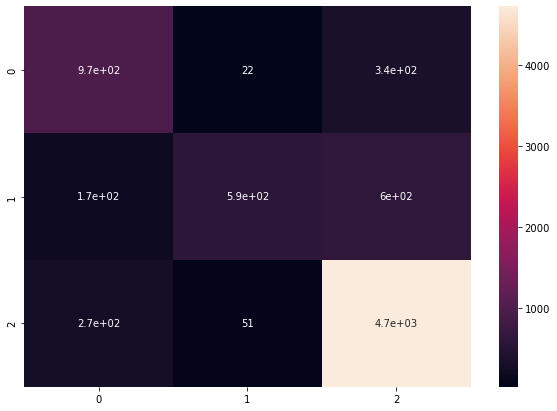

In [127]:
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot=True)

### Comparing Metrics to Baseline Model

In [129]:
y_pred2.shape

(7730,)

In [130]:
y_pred2.dtype

dtype('int64')

In [131]:
baseline = np.full([7730], 3, dtype = int)
print(baseline)

[3 3 3 ... 3 3 3]


In [132]:
accuracy_score(y_test, baseline)

0.6527813712807244

In [137]:
f1_score(y_test, baseline, average = None)

array([0.       , 0.       , 0.7899186])

In [135]:
f1_score(y_test, baseline, average = 'macro')

0.2633061991233563

In [136]:
f1_score(y_test, baseline, average = 'weighted')

0.51564414519138

The baseline metrics in comparison to my model metrics (weighted f1 score 0.52 for baseline compared to 0.80 for my final model) suggest that my model is performing well in comparison to the baseline model and that it can accurately predict drug rating from the given predictors.

### Conclusion

My final model will be the Random Forest Classifier predicting 3 classes of Ratings (low, medium, & high). The final model is restated in a mardown cell below:

rfc = RandomForestClassifier(n_estimators = 1000, max_depth = 24, max_features = 9, class_weight = 'balanced_subsample',
oob_score = True, criterion = 'entropy')

Overall, this model is pretty good but still a bit overfit. I can continue improving this model by working on the feature selection and feature engineering more, and perhaps tuning the hyperparameters differently.